## **Loading The Dataset**


In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 99% 162M/163M [00:09<00:00, 22.8MB/s]
100% 163M/163M [00:09<00:00, 19.0MB/s]


In [4]:
from zipfile import ZipFile

with ZipFile("/content/face-mask-dataset.zip", "r") as f:
  f.extractall()
  print("Files successfully extracted")

Files successfully extracted


## **Importing Packages**

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer

In [6]:
# Loading files with and without facemask from their different directories into a list

with_mask_images = os.listdir("/content/data/with_mask")
without_mask_images = os.listdir("/content/data/without_mask")

In [7]:
print(len(with_mask_images))
print(len(without_mask_images))

3725
3828


In [8]:
print(with_mask_images[:5])
print(without_mask_images[:5])

['with_mask_1520.jpg', 'with_mask_1473.jpg', 'with_mask_2764.jpg', 'with_mask_2873.jpg', 'with_mask_2412.jpg']
['without_mask_894.jpg', 'without_mask_2086.jpg', 'without_mask_3724.jpg', 'without_mask_1718.jpg', 'without_mask_1630.jpg']


## **Image Processing**

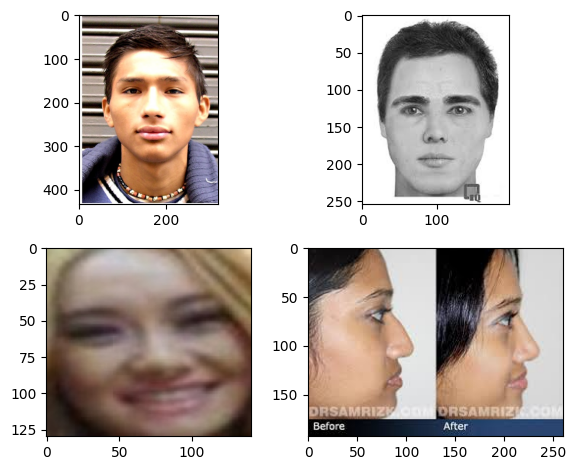

In [9]:
# Visualizing Images Without Mask

for idx, image in enumerate(without_mask_images[:4]):
  plt.subplot(2,2, idx+1)
  img_path = os.path.join("/content/data/without_mask/", image)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.tight_layout()
plt.show()

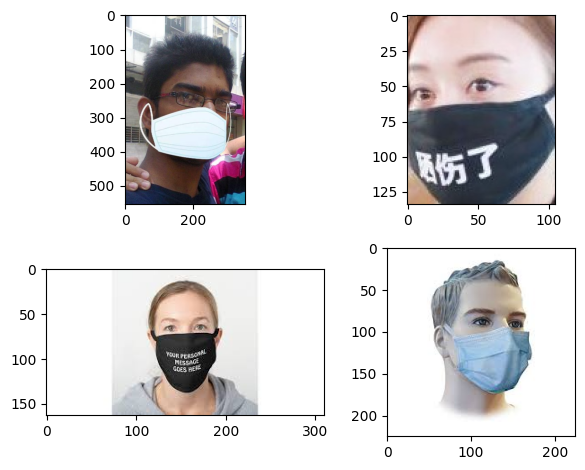

In [10]:
# Visualizing Images With Mask

for idx, image in enumerate(with_mask_images[:4]):
  plt.subplot(2,2, idx+1)
  img_path = os.path.join("/content/data/with_mask/", image)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.tight_layout()
plt.show()

In [11]:
# Checking the shape of first four images in the dataset

for image in with_mask_images[:3]:
  img_path = os.path.join("/content/data/with_mask/", image)
  image = cv2.imread(img_path)
  print(image.shape)

(554, 353, 3)
(134, 105, 3)
(163, 310, 3)


In [12]:
images = []

for image in with_mask_images:
  img_path = os.path.join("/content/data/with_mask/", image)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (128,128))
  if len(img.shape) == 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  elif len(img.shape) == 3 and img.shape[2] == 1:
    img = cv2.merge([img[:,:,0], img[:,:,0], img[:,:,0]])
  images.append(img)

In [13]:
len(images)

3725

In [14]:
for image in without_mask_images:
  img_path = os.path.join("/content/data/without_mask/", image)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (128,128))
  if len(img.shape) == 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  elif len(img.shape) == 3 and img.shape[2] == 1:
    img = cv2.merge([img[:,:,0], img[:,:,0], img[:,:,0]])
  images.append(img)

In [15]:
len(images)

7553

In [16]:
type(images)

list

In [17]:
images[:3]

[array([[[153, 139, 124],
         [156, 143, 127],
         [160, 144, 131],
         ...,
         [230, 230, 229],
         [243, 243, 243],
         [251, 253, 253]],
 
        [[156, 143, 127],
         [158, 145, 129],
         [164, 148, 135],
         ...,
         [246, 245, 245],
         [236, 236, 236],
         [238, 241, 241]],
 
        [[156, 143, 127],
         [160, 148, 131],
         [163, 147, 134],
         ...,
         [254, 254, 253],
         [254, 254, 254],
         [252, 254, 254]],
 
        ...,
 
        [[ 87,  53,  37],
         [ 77,  43,  27],
         [ 80,  46,  30],
         ...,
         [170, 136,  37],
         [176, 140,  36],
         [177, 140,  33]],
 
        [[ 82,  46,  30],
         [ 79,  43,  27],
         [ 80,  44,  28],
         ...,
         [173, 140,  36],
         [174, 142,  37],
         [178, 146,  39]],
 
        [[ 97,  58,  43],
         [ 86,  46,  31],
         [ 85,  45,  30],
         ...,
         [177, 145,  41],
  

In [18]:
# Normalizing images and converting them to numpy arrays

images = np.array(images)/255
images[0]

array([[[0.6       , 0.54509804, 0.48627451],
        [0.61176471, 0.56078431, 0.49803922],
        [0.62745098, 0.56470588, 0.51372549],
        ...,
        [0.90196078, 0.90196078, 0.89803922],
        [0.95294118, 0.95294118, 0.95294118],
        [0.98431373, 0.99215686, 0.99215686]],

       [[0.61176471, 0.56078431, 0.49803922],
        [0.61960784, 0.56862745, 0.50588235],
        [0.64313725, 0.58039216, 0.52941176],
        ...,
        [0.96470588, 0.96078431, 0.96078431],
        [0.9254902 , 0.9254902 , 0.9254902 ],
        [0.93333333, 0.94509804, 0.94509804]],

       [[0.61176471, 0.56078431, 0.49803922],
        [0.62745098, 0.58039216, 0.51372549],
        [0.63921569, 0.57647059, 0.5254902 ],
        ...,
        [0.99607843, 0.99607843, 0.99215686],
        [0.99607843, 0.99607843, 0.99607843],
        [0.98823529, 0.99607843, 0.99607843]],

       ...,

       [[0.34117647, 0.20784314, 0.14509804],
        [0.30196078, 0.16862745, 0.10588235],
        [0.31372549, 0

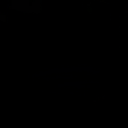

In [19]:
cv2_imshow(images[0])

## **Preparing Dataset Labels**

In [20]:
with_mask_labels = np.zeros(len(with_mask_images))
without_mask_labels = np.ones(len(without_mask_images))

In [21]:
labels = np.concatenate((with_mask_labels, without_mask_labels))

In [22]:
type(labels), type(images)

(numpy.ndarray, numpy.ndarray)

In [23]:
X = images
y = labels

## **Splitting Data Into Training and Test Set**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, X_train.shape, X_test.shape)

(7553, 128, 128, 3) (6042, 128, 128, 3) (1511, 128, 128, 3)


In [25]:
print(y.shape, y_train.shape, y_test.shape)

(7553,) (6042,) (1511,)


## **Building a Neural Network**

In [26]:
model = Sequential()
model.add(InputLayer(input_shape=(128,128,3)))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 127, 127, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,889,698 (30.10 MB)

 Trainable params: 7,889,698 (30.10 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [28]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=5)

Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.6765 - loss: 0.7817 - val_accuracy: 0.9041 - val_loss: 0.2473
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8650 - loss: 0.3281 - val_accuracy: 0.9140 - val_loss: 0.2181
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8925 - loss: 0.2616 - val_accuracy: 0.9207 - val_loss: 0.2044
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9108 - loss: 0.2293 - val_accuracy: 0.8959 - val_loss: 0.2657
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9190 - loss: 0.1988 - val_accuracy: 0.9273 - val_loss: 0.1909


## **Model Evaluation on the Test Data**

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9092 - loss: 0.2042
Loss:  0.20467638969421387
Accuracy:  0.9179351329803467


## **Visualizing Model Performance**

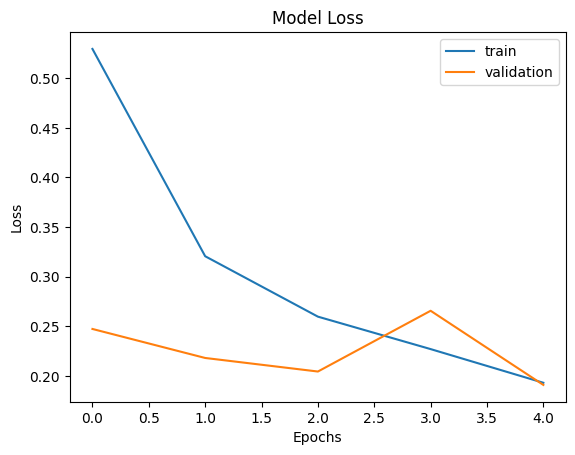

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

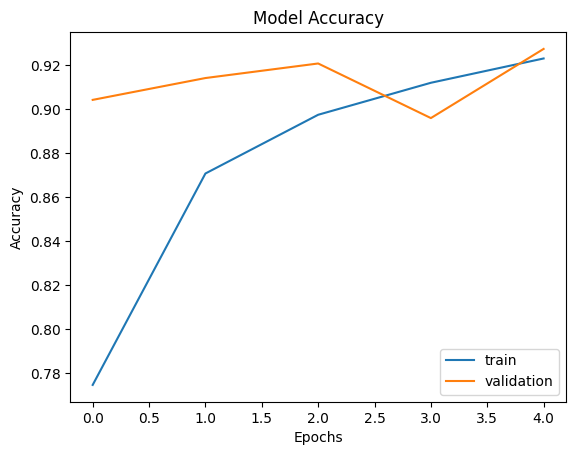

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

## **Building a Predictive System**

In [ ]:
input_image_path = input('Provide an Image Path')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image = cv2.resize(input_image, (128,128))

if len(input_image.shape) == 2:
  input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)
elif len(input_image.shape) == 3 and input_image[2] == 1:
  input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)

input_image = input_image/255

input_image_reshaped = np.reshape(input_image, (1,128,128,3))

pred_prob = model.predict(input_image_reshaped)

pred = np.argmax(pred_prob)

if pred == 0:
  print('The image contains a person wearing a face mask!')
else:
  print('The image contains a person without a face mask!')